In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.quantization

# Set device (use CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [2]:
N = 20

# Define the transformation to normalize MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Load MNIST testing dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine datasets
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

import random

def split_dataset(combined_dataset, N):
    # Total number of samples in the dataset
    M = len(combined_dataset)
    indices = list(range(M))
    split_size = M // N
    
    # Shuffle indices to ensure randomness in splitting
    random.shuffle(indices)
    
    # Split indices into N parts
    user_data = [indices[i * split_size:(i + 1) * split_size] for i in range(N)]
    
    # Create subsets for each user
    user_datasets = [torch.utils.data.Subset(combined_dataset, user_data[i]) for i in range(N)]
    
    return user_datasets


def split_train_test(user_dataset, test_ratio=0.2):
    # Total number of samples
    M = len(user_dataset)
    test_size = int(M * test_ratio)
    train_size = M - test_size
    
    # Split the dataset into training and testing sets
    train_subset, test_subset = random_split(user_dataset, [train_size, test_size])
    
    return train_subset, test_subset


user_datasets = split_dataset(combined_dataset, N)

batch_size = 64  # Adjust batch size as needed

# Split user-specific dataset into training and testing sets
user_train_loaders = []
user_test_loaders = []
for user_dataset in user_datasets:
    train_data, test_data = split_train_test(user_dataset)
    user_train_loaders.append(DataLoader(train_data, batch_size=batch_size, shuffle=True))
    user_test_loaders.append(DataLoader(test_data, batch_size=batch_size, shuffle=False))
    
def aggregate_updates(local_updates):
    # A naive method to aggregate model weights
    new_state_dict = {}
    for key in local_updates[0].keys():
        new_state_dict[key] = torch.mean(torch.stack([update[key] for update in local_updates]), dim=0)
    return new_state_dict

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.quant(x)
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.reshape(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
global_model = Net().to(device)

client_models = [Net().to(device) for i in range(N)]

for model in client_models + [global_model]:
    # Fuse layers (for better optimization during quantization)
    model.fuse_model = lambda: torch.quantization.fuse_modules(model, [["conv1", "relu1"], ["conv2", "relu2"]])
    model.fuse_model()
    
    # Specify quantization configuration
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    
    # Prepare for QAT
    model = torch.quantization.prepare_qat(model)




C:\Users\abdu_\anaconda3\envs\fmtl_sheaves\lib\site-packages\torch\ao\quantization\observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [5]:
avg_train_losses_q = []  # Average training loss per epoch
avg_train_accs_q = []    # Average training accuracy per epoch
avg_test_losses_q = []   # Average testing loss per epoch
avg_test_accs_q = []     # Average testing accuracy per epoch

def federated_train(global_model, client_models, user_train_loaders, user_test_loaders, epochs):
    for epoch in range(epochs):
        local_updates = []
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []

        for i in range(N):
            # Copy the global model for each user
            client_models[i].load_state_dict(global_model.state_dict())
            optimizer = torch.optim.SGD(client_models[i].parameters(), lr=0.01)  # Example with SGD optimizer

            user_train_loss = 0.0
            user_train_correct = 0
            user_train_samples = 0

            # Train the local model on the user's training data
            client_models[i].train()
            for j, (data, target) in zip(range(2), user_train_loaders[i]):
                optimizer.zero_grad()
                output = client_models[i](data)
                loss = torch.nn.functional.cross_entropy(output, target)
                loss.backward()
                optimizer.step()

                # Accumulate training loss and accuracy
                user_train_loss += loss.item() * len(data)
                _, predicted = torch.max(output, 1)
                user_train_correct += (predicted == target).sum().item()
                user_train_samples += len(data)

            # Calculate and store the training loss and accuracy for this user
            train_losses.append(user_train_loss / user_train_samples)
            train_accs.append(100 * user_train_correct / user_train_samples)

            # Save the local model state dict
            local_updates.append(client_models[i].state_dict())

            # Evaluate on the test set of the user
            user_test_loss = 0.0
            user_test_correct = 0
            user_test_samples = 0

            client_models[i].eval()
            with torch.no_grad():
                for data, target in user_test_loaders[i]:
                    output = client_models[i](data)
                    loss = torch.nn.functional.cross_entropy(output, target)
                    user_test_loss += loss.item() * len(data)
                    _, predicted = torch.max(output, 1)
                    user_test_correct += (predicted == target).sum().item()
                    user_test_samples += len(data)

            # Calculate and store the testing loss and accuracy for this user
            test_losses.append(user_test_loss / user_test_samples)
            test_accs.append(100 * user_test_correct / user_test_samples)

            print(f"User {i+1} - Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.2f}% - "
                  f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accs[-1]:.2f}%")

        # Aggregate updates from all users
        aggregated_model_state = aggregate_updates(local_updates)
        global_model.load_state_dict(aggregated_model_state)

        # Calculate epoch-level averages and store them
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_acc = sum(train_accs) / len(train_accs)
        avg_test_loss = sum(test_losses) / len(test_losses)
        avg_test_acc = sum(test_accs) / len(test_accs)

        avg_train_losses_q.append(avg_train_loss)
        avg_train_accs_q.append(avg_train_acc)
        avg_test_losses_q.append(avg_test_loss)
        avg_test_accs_q.append(avg_test_acc)

        print(f"Epoch {epoch+1}/{epochs} completed - "
              f"Avg Train Loss: {avg_train_loss:.4f}, Avg Train Accuracy: {avg_train_acc:.2f}%, "
              f"Avg Test Loss: {avg_test_loss:.4f}, Avg Test Accuracy: {avg_test_acc:.2f}%")
    


# Example usage
# global_model = Net().to(device)
federated_train(global_model, client_models, user_train_loaders, user_test_loaders, epochs=100)


User 1 - Epoch 1/100 - Train Loss: 2.3216, Train Accuracy: 3.12% - Test Loss: 2.3094, Test Accuracy: 5.29%
User 2 - Epoch 1/100 - Train Loss: 2.3128, Train Accuracy: 7.03% - Test Loss: 2.3101, Test Accuracy: 6.14%
User 3 - Epoch 1/100 - Train Loss: 2.3032, Train Accuracy: 10.94% - Test Loss: 2.3138, Test Accuracy: 8.86%
User 4 - Epoch 1/100 - Train Loss: 2.3087, Train Accuracy: 8.59% - Test Loss: 2.3110, Test Accuracy: 7.00%
User 5 - Epoch 1/100 - Train Loss: 2.3062, Train Accuracy: 5.47% - Test Loss: 2.3092, Test Accuracy: 8.00%
User 6 - Epoch 1/100 - Train Loss: 2.2978, Train Accuracy: 15.62% - Test Loss: 2.3111, Test Accuracy: 9.43%
User 7 - Epoch 1/100 - Train Loss: 2.3095, Train Accuracy: 7.03% - Test Loss: 2.3106, Test Accuracy: 7.29%
User 8 - Epoch 1/100 - Train Loss: 2.3208, Train Accuracy: 3.91% - Test Loss: 2.3098, Test Accuracy: 7.14%
User 9 - Epoch 1/100 - Train Loss: 2.3102, Train Accuracy: 7.81% - Test Loss: 2.3119, Test Accuracy: 8.14%
User 10 - Epoch 1/100 - Train Loss:

In [6]:
model_quantized = torch.quantization.convert(global_model)


In [7]:
# Evaluate quantized model
model_quantized.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_quantized(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the quantized model on the test set: {100 * correct / total:.2f}%")


Accuracy of the quantized model on the test set: 69.52%


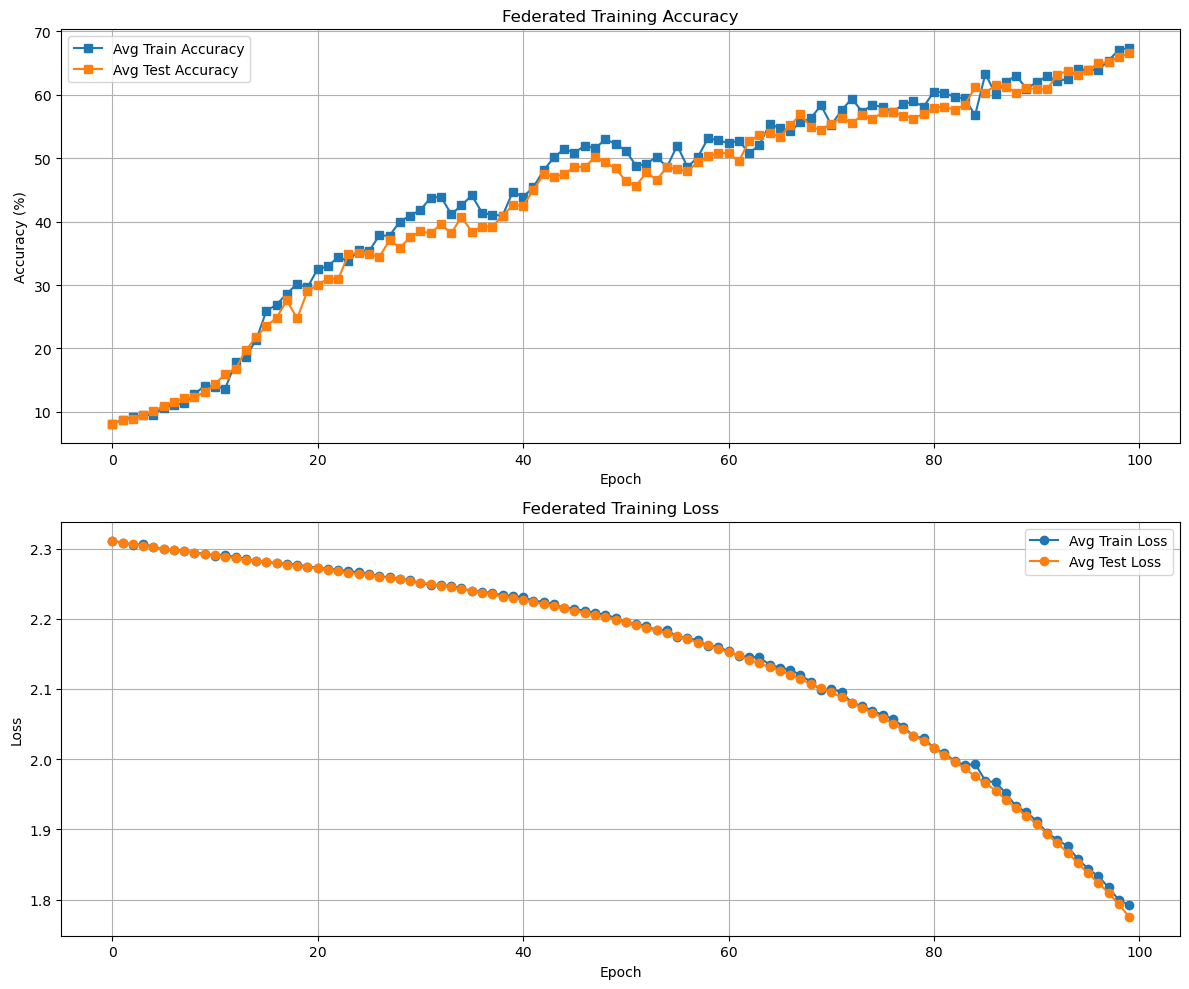

In [8]:
import matplotlib.pyplot as plt

# Plotting the metrics as subplots
plt.figure(figsize=(12, 10))

# Subplot 1: Accuracy
plt.subplot(2, 1, 1)
plt.plot(avg_train_accs_q, label='Avg Train Accuracy', marker='s')
plt.plot(avg_test_accs_q, label='Avg Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Federated Training Accuracy')
plt.legend()
plt.grid()

# Subplot 2: Loss
plt.subplot(2, 1, 2)
plt.plot(avg_train_losses_q, label='Avg Train Loss', marker='o')
plt.plot(avg_test_losses_q, label='Avg Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Federated Training Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


C:\Users\abdu_\anaconda3\envs\fmtl_sheaves\lib\site-packages\torch\ao\quantization\observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


User 1 - Epoch 1/100 - Train Loss: 2.3158, Train Accuracy: 12.50% - Test Loss: 2.3014, Test Accuracy: 9.14%
User 2 - Epoch 1/100 - Train Loss: 2.3082, Train Accuracy: 10.16% - Test Loss: 2.3035, Test Accuracy: 12.14%
User 3 - Epoch 1/100 - Train Loss: 2.3041, Train Accuracy: 9.38% - Test Loss: 2.3017, Test Accuracy: 9.86%
User 4 - Epoch 1/100 - Train Loss: 2.2989, Train Accuracy: 9.38% - Test Loss: 2.3059, Test Accuracy: 11.43%
User 5 - Epoch 1/100 - Train Loss: 2.2959, Train Accuracy: 12.50% - Test Loss: 2.3070, Test Accuracy: 9.57%
User 6 - Epoch 1/100 - Train Loss: 2.3090, Train Accuracy: 11.72% - Test Loss: 2.2977, Test Accuracy: 12.43%
User 7 - Epoch 1/100 - Train Loss: 2.2972, Train Accuracy: 11.72% - Test Loss: 2.3017, Test Accuracy: 10.00%
User 8 - Epoch 1/100 - Train Loss: 2.2930, Train Accuracy: 8.59% - Test Loss: 2.2983, Test Accuracy: 8.86%
User 9 - Epoch 1/100 - Train Loss: 2.3073, Train Accuracy: 12.50% - Test Loss: 2.3068, Test Accuracy: 11.14%
User 10 - Epoch 1/100 - Tr

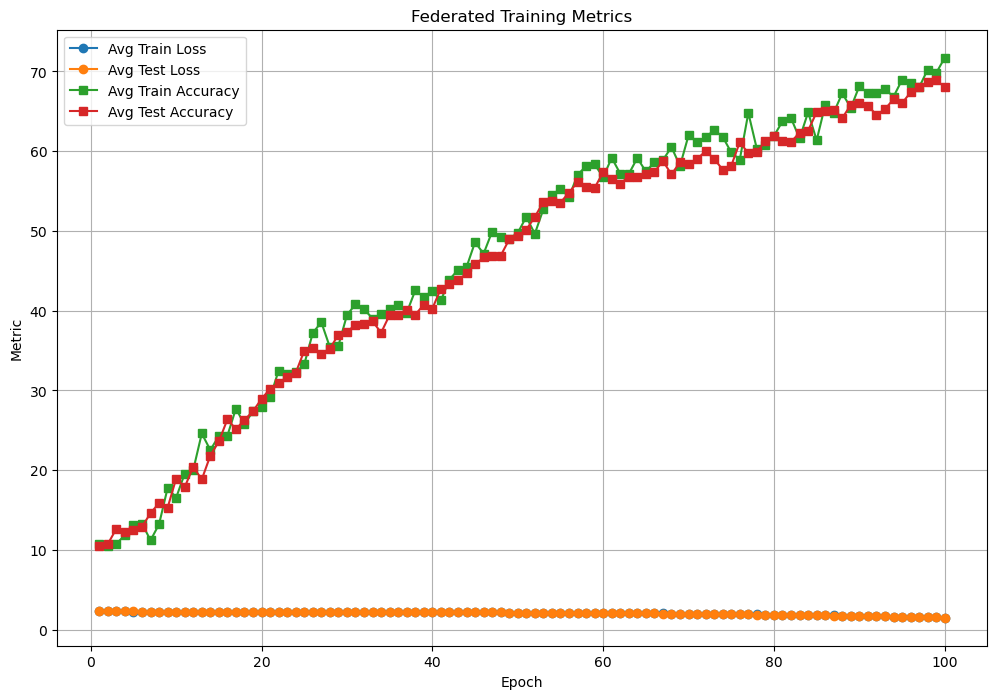

Accuracy of the quantized model on the test set: 69.52%


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.reshape(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

global_model = Net().to(device)

client_models = [Net().to(device) for i in range(N)]

for model in client_models + [global_model]:
    # Fuse layers (for better optimization during quantization)
    model.fuse_model = lambda: torch.quantization.fuse_modules(model, [["conv1", "relu1"], ["conv2", "relu2"]])
    model.fuse_model()
    
    # Specify quantization configuration
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    
    # Prepare for QAT
    model = torch.quantization.prepare_qat(model)


avg_train_losses = []  # Average training loss per epoch
avg_train_accs = []    # Average training accuracy per epoch
avg_test_losses = []   # Average testing loss per epoch
avg_test_accs = []     # Average testing accuracy per epoch

def federated_train(global_model, client_models, user_train_loaders, user_test_loaders, epochs):
    for epoch in range(epochs):
        local_updates = []
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []

        for i in range(N):
            # Copy the global model for each user
            client_models[i].load_state_dict(global_model.state_dict())
            optimizer = torch.optim.SGD(client_models[i].parameters(), lr=0.01)  # Example with SGD optimizer

            user_train_loss = 0.0
            user_train_correct = 0
            user_train_samples = 0

            # Train the local model on the user's training data
            client_models[i].train()
            for j, (data, target) in zip(range(2), user_train_loaders[i]):
                optimizer.zero_grad()
                output = client_models[i](data)
                loss = torch.nn.functional.cross_entropy(output, target)
                loss.backward()
                optimizer.step()

                # Accumulate training loss and accuracy
                user_train_loss += loss.item() * len(data)
                _, predicted = torch.max(output, 1)
                user_train_correct += (predicted == target).sum().item()
                user_train_samples += len(data)

            # Calculate and store the training loss and accuracy for this user
            train_losses.append(user_train_loss / user_train_samples)
            train_accs.append(100 * user_train_correct / user_train_samples)

            # Save the local model state dict
            local_updates.append(client_models[i].state_dict())

            # Evaluate on the test set of the user
            user_test_loss = 0.0
            user_test_correct = 0
            user_test_samples = 0

            client_models[i].eval()
            with torch.no_grad():
                for data, target in user_test_loaders[i]:
                    output = client_models[i](data)
                    loss = torch.nn.functional.cross_entropy(output, target)
                    user_test_loss += loss.item() * len(data)
                    _, predicted = torch.max(output, 1)
                    user_test_correct += (predicted == target).sum().item()
                    user_test_samples += len(data)

            # Calculate and store the testing loss and accuracy for this user
            test_losses.append(user_test_loss / user_test_samples)
            test_accs.append(100 * user_test_correct / user_test_samples)

            print(f"User {i+1} - Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.2f}% - "
                  f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accs[-1]:.2f}%")

        # Aggregate updates from all users
        aggregated_model_state = aggregate_updates(local_updates)
        global_model.load_state_dict(aggregated_model_state)

        # Calculate epoch-level averages and store them
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_acc = sum(train_accs) / len(train_accs)
        avg_test_loss = sum(test_losses) / len(test_losses)
        avg_test_acc = sum(test_accs) / len(test_accs)

        avg_train_losses.append(avg_train_loss)
        avg_train_accs.append(avg_train_acc)
        avg_test_losses.append(avg_test_loss)
        avg_test_accs.append(avg_test_acc)

        print(f"Epoch {epoch+1}/{epochs} completed - "
              f"Avg Train Loss: {avg_train_loss:.4f}, Avg Train Accuracy: {avg_train_acc:.2f}%, "
              f"Avg Test Loss: {avg_test_loss:.4f}, Avg Test Accuracy: {avg_test_acc:.2f}%")
    
    # Plotting the metrics
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, epochs + 1), avg_train_losses, label='Avg Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), avg_test_losses, label='Avg Test Loss', marker='o')
    plt.plot(range(1, epochs + 1), avg_train_accs, label='Avg Train Accuracy', marker='s')
    plt.plot(range(1, epochs + 1), avg_test_accs, label='Avg Test Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Federated Training Metrics')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
# global_model = Net().to(device)
federated_train(global_model, client_models, user_train_loaders, user_test_loaders, epochs=100)


# Evaluate quantized model
model_quantized.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_quantized(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the quantized model on the test set: {100 * correct / total:.2f}%")


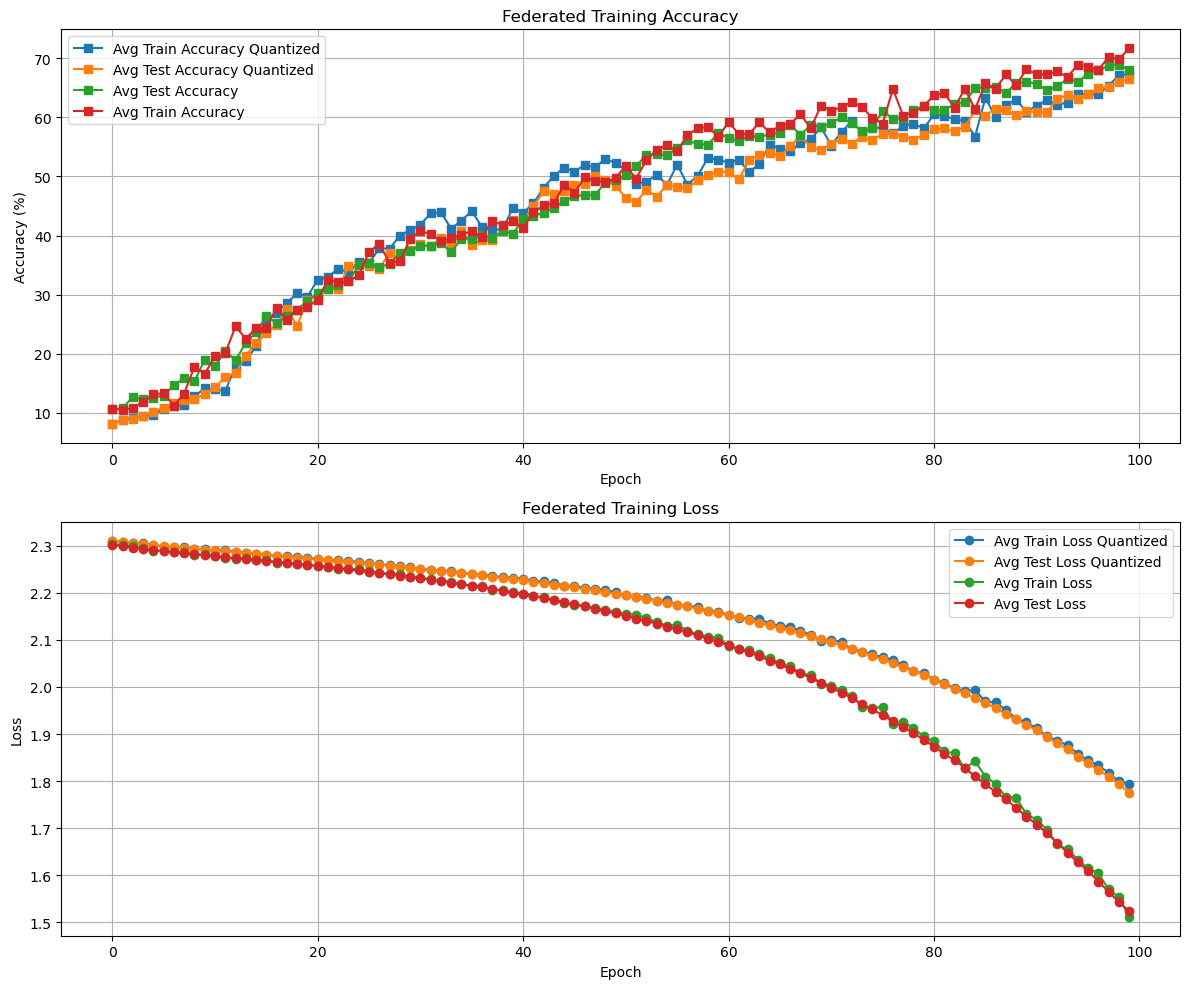

In [13]:
import matplotlib.pyplot as plt

# Plotting the metrics as subplots
plt.figure(figsize=(12, 10))

# Subplot 1: Accuracy
plt.subplot(2, 1, 1)
plt.plot(avg_train_accs_q, label='Avg Train Accuracy Quantized', marker='s')
plt.plot(avg_test_accs_q, label='Avg Test Accuracy Quantized', marker='s')
plt.plot(avg_test_accs, label='Avg Test Accuracy', marker='s')
plt.plot(avg_train_accs, label='Avg Train Accuracy', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Federated Training Accuracy')
plt.legend()
plt.grid()

# Subplot 2: Loss
plt.subplot(2, 1, 2)
plt.plot(avg_train_losses_q, label='Avg Train Loss Quantized', marker='o')
plt.plot(avg_test_losses_q, label='Avg Test Loss Quantized', marker='o')
plt.plot(avg_train_losses, label='Avg Train Loss', marker='o')
plt.plot(avg_test_losses, label='Avg Test Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Federated Training Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [12]:
num_elems = sum([p.numel() for p in model_quantized.parameters()])

In [11]:
[p.numel() for p in model_prepared.parameters()]

NameError: name 'model_prepared' is not defined

In [ ]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [15]:
import numpy as np

# Parameters
num_users = 20                 # Number of users
area_size = 1000                # 100 x 100 m^2 area
Pt = 100e-3                    # Transmission power (100 mW)
B = 2e6                        # Bandwidth (2 MHz)
N0 = 1e-9                      # Noise spectral density (10^-9 W/Hz)
model_size_bits = 32 * 1e6     # Model size: 32-bit representation of 1M elements

# Fixed server position (e.g., at the center of the area)
server_x, server_y = area_size / 2, area_size / 2

# Monte Carlo simulation to calculate average bit rate
num_iterations = 1000          # Number of Monte Carlo iterations
bit_rates = []                 # To store bit rates for each iteration

for _ in range(num_iterations):
    # Randomly distribute users in 100x100 area
    user_x_coords = np.random.uniform(0, area_size, num_users)
    user_y_coords = np.random.uniform(0, area_size, num_users)
    
    # Calculate distances to the server
    distances = np.sqrt((user_x_coords - server_x)**2 + (user_y_coords - server_y)**2)
    distances = np.clip(distances, 1, None)  # Avoid zero distance; minimum distance = 1 m
    
    # Calculate achievable bit rates for all users
    rates = B * np.log2(1 + (Pt / (distances**2 * B * N0)))
    
    # Compute average bit rate across all users in this iteration
    avg_rate = np.mean(rates)
    bit_rates.append(avg_rate)

# Calculate the final average bit rate over all iterations
avg_bit_rate = np.mean(bit_rates)
print(f"Average Bit Rate: {avg_bit_rate:.2f} bps")




Average Bit Rate: 4769.72 bps
Energy Required to Transmit the Model: 670.90 Joules


In [32]:
# Calculate energy required to transmit the model to the server
transmission_time = model_size_bits / avg_bit_rate  # Time to transmit the model
energy_per_round = Pt * transmission_time  # Energy consumption

print(f"Energy Required to Transmit the Model: {energy_per_round:.2f} Joules per round")



Energy Required to Transmit the Model: 670.90 Joules per round


In [33]:
target_acc = 65.0

In [34]:
target_acc_rounds_qunatized = sum([i < target_acc for i in avg_test_accs_q])
target_acc_rounds = sum([i < target_acc for i in avg_test_accs])


In [35]:
# Energy for the quantized model to achieve 65 Accuracy Accuracy
total_energy_quantized = target_acc_rounds_qunatized * energy_per_round / 4

# Energy for normal model to achieve 65 Accuracy
total_energy = target_acc_rounds * energy_per_round


In [37]:
print(f"Total energy for quantized model to achieve {target_acc}: {total_energy_quantized} Joules")
print(f"Total energy for quantized model to achieve {target_acc}: {total_energy} Joules")

energy_savings = (total_energy - total_energy_quantized) / total_energy
print(f"Energy savings: {energy_savings * 100} %")


Total energy for quantized model to achieve 65.0: 16269.308087300247 Joules
Total energy for quantized model to achieve 65.0: 58368.23932351016 Joules
Energy savings: 72.12643678160919 %
